In [1]:
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import keras
import numpy as np
import math
from keras import layers, optimizers, callbacks, preprocessing, ops
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [2]:
EPOCH = 300

train_data = preprocessing.image_dataset_from_directory(
    '/Users/rudisargueta/Documents/Alzheimer_CNN/AlzheimersDataset/train',   
    validation_split=.2, 
    labels='inferred', 
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32, 
    seed=1337,
    image_size=(128, 128),
    shuffle=True,
    subset='training',
)

val_data = preprocessing.image_dataset_from_directory(
    '/Users/rudisargueta/Documents/Alzheimer_CNN/AlzheimersDataset/train',   
    validation_split=.2, 
    labels='inferred', 
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32, 
    seed=1337,
    image_size=(128, 128),
    shuffle= True,
    subset='validation',
)


test_data = preprocessing.image_dataset_from_directory(
    '/Users/rudisargueta/Documents/Alzheimer_CNN/AlzheimersDataset/test',    
    labels='inferred', 
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32, 
    seed=1337,
    image_size=(128, 128),
)

class_names = ['MildDementia', 'NonDementia', 'VeryMildDementia']
train_data.class_names = class_names
val_data.class_names = class_names


Found 5121 files belonging to 3 classes.
Using 4097 files for training.
Found 5121 files belonging to 3 classes.
Using 1024 files for validation.
Found 1279 files belonging to 3 classes.


2024-05-02 21:44:26.713755: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-02 21:44:26.713782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-02 21:44:26.713785: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-02 21:44:26.713823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-02 21:44:26.713843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model = keras.models.Sequential()
model.add(layers.Input(shape=(128,128,1)))
model.add(layers.RandomFlip(mode='horizontal'))
model.add(layers.RandomZoom(0.05, fill_mode='nearest'))
model.add(layers.RandomRotation(0.05, fill_mode='nearest'))
model.add(layers.RandomTranslation(0.05, 0.05, fill_mode='nearest'))  
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', 'auc', 'f1_score']
)

def scheduler(epoch, lr):
    if epoch < 150:
        return lr
    else:
        return 1e-5



exp_decay = callbacks.LearningRateScheduler(scheduler)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

save_best_model = callbacks.ModelCheckpoint('best_cnn_model.keras', save_best_only=True)

early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_data, validation_data = val_data, callbacks=[exp_decay], epochs= EPOCH)

Epoch 1/300


2024-05-02 21:44:27.504179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 21:44:27.797704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4467 - auc: 0.6172 - f1_score: 0.3747 - loss: 4.8466

2024-05-02 21:44:35.704280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.4469 - auc: 0.6175 - f1_score: 0.3749 - loss: 4.8259 - val_accuracy: 0.5352 - val_auc: 0.7300 - val_f1_score: 0.4009 - val_loss: 1.0610 - learning_rate: 1.0000e-04
Epoch 2/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5254 - auc: 0.7214 - f1_score: 0.4397 - loss: 1.0663 - val_accuracy: 0.5352 - val_auc: 0.7280 - val_f1_score: 0.4231 - val_loss: 0.9917 - learning_rate: 1.0000e-04
Epoch 3/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5296 - auc: 0.7315 - f1_score: 0.4428 - loss: 0.9922 - val_accuracy: 0.5674 - val_auc: 0.7704 - val_f1_score: 0.4846 - val_loss: 0.8816 - learning_rate: 1.0000e-04
Epoch 4/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5518 - auc: 0.7446 - f1_score: 0.4683 - loss: 0.9426 - val_accuracy: 0.5449 - val_auc: 0.7579 - val_f1_score: 0.4182 - val_loss: 0.9681 - learning_rate: 1.0000e-04
Epoch 5/300
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5552 - auc: 0.76

In [5]:
evaluate = model.evaluate(test_data)
print(evaluate)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6488 - auc: 0.8072 - f1_score: 0.6121 - loss: 2.0450
[2.121506929397583, 0.6458170413970947, 0.8013200163841248, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.55595666, 0.766117  , 0.480597  ], dtype=float32)>]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-05-02 22:23:07.660783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

2024-05-02 22:23:08.964363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


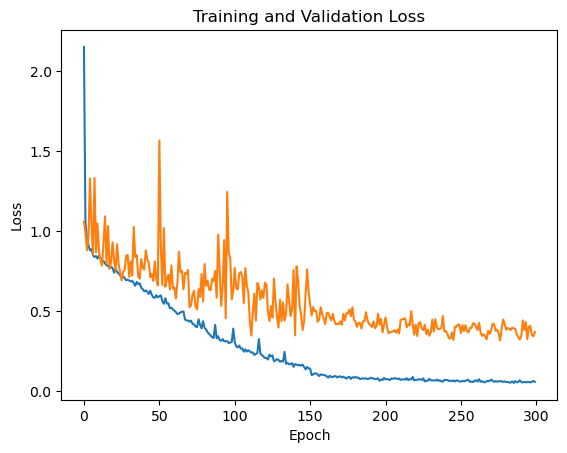

[[154  76 133]
 [ 29 511 154]
 [  8  53 161]]


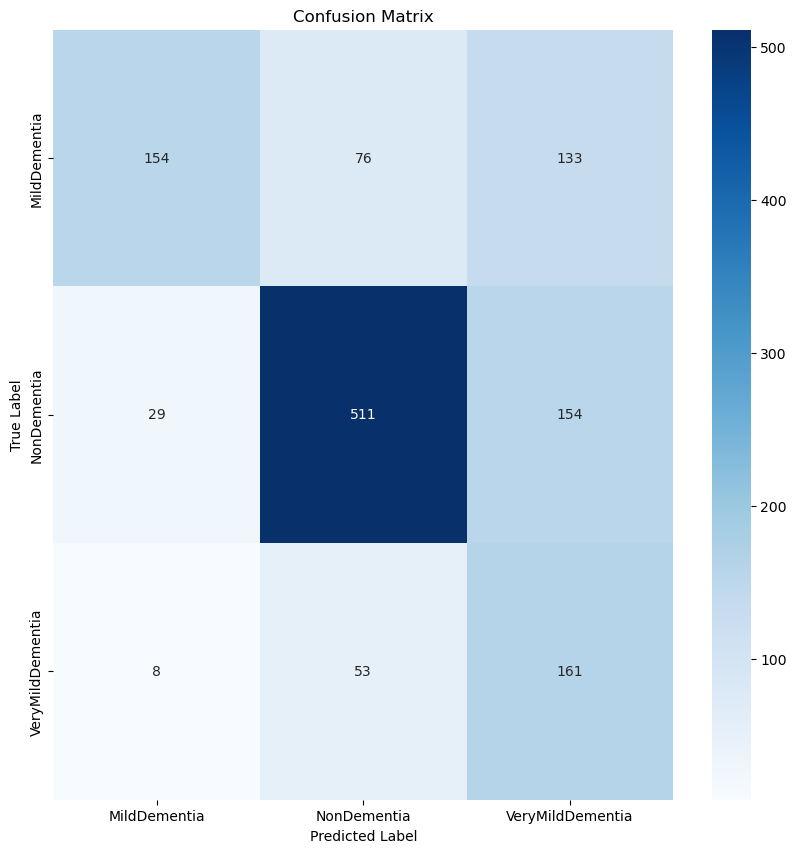

In [6]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_data:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion = confusion_matrix(predictions, labels)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Valadation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()




print(confusion)
plt.figure(figsize=(10,10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()